## Perceptual Hashing Experiment
The goal of this notebook is to explore perceptual hashing as a way to efficiently store images and search for similar images.

This notebook sets up the basic "Image Augmentation pipeline", "Search Database Functionality", and "Testing Framework" that we can use for future image similarity methodologies.


In [50]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy
from sklearn.metrics import classification_report
from augraphy import *

## settings
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [51]:
## load metadata
dataset_name = "interim/mendeley-chestxray-2017"
dataset_metadata_path = os.path.join("/mnt/azureblobshare/data/duplicate_detection", dataset_name, "df_complete_raw_data_locations.pkl")
img_df = pd.read_pickle(dataset_metadata_path)
train_df = img_df[img_df["data_type"] == "train"]
valid_df = img_df[img_df["data_type"] == "valid"]
test_df = img_df[img_df["data_type"] == "test"]


### Utility Functions

In [52]:
def hash_array_to_hash_hex(hash_array):
    # convert hash array of 0 or 1 to hash string in hex
    hash_array = np.array(hash_array, dtype = np.uint8)
    hash_str = ''.join(str(i) for i in 1 * hash_array.flatten())
    return (hex(int(hash_str, 2)))

def hash_hex_to_hash_array(hash_hex):
    # convert hash string in hex to hash values of 0 or 1
    hash_str = int(hash_hex, 16)
    array_str = bin(hash_str)[2:]
    return np.array([i for i in array_str], dtype = np.float32)

def display_image(filename):
    # plot image for debugging given an absolute path to the file
    img = mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()

### Search Database Functionalities
regardless of methodology we choose, there should be a type of search database functionality to check for duplicate images

In [53]:
## This dictionary acts as a global hash/embedding database
HASH_DATABASE = {}

In [54]:
## Function to save hash value of a given image to "database"
def save_hash(filename, img):
    img_hash = calculate_hash(img)
    HASH_DATABASE[filename] = img_hash


In [55]:
## Function to query a hash "database" given a single image, returns the closest image and the distance to the query image
def check_duplicate(img):
    img_hash = calculate_hash(img)
    img_hash_hex = hash_hex_to_hash_array(img_hash)
    closest_image = None
    closest_distance = 999
    for image_name in HASH_DATABASE.keys():
        distance = scipy.spatial.distance.hamming(
                                hash_hex_to_hash_array(HASH_DATABASE[image_name]), 
                                img_hash_hex
                                )
        if distance < closest_distance:
            closest_image = image_name
            closest_distance = distance
    return closest_image, closest_distance


### Image Augmentation Pipeline with Keras ImageDataGenerator

In [56]:
## Function that augments the image with random distortion to mimic how they show up in documents
def custom_augmentation(img):
    ink_phase   = [
#         Dithering(
#             dither="ordered",
#             order=2,
#             p=1
#         ),
    ]
    paper_phase = [

    ]
    post_phase  = [

        Jpeg(
            quality_range=(10, 10),
            p=1,
        ),
#             Geometric(
#             rotate_range=(180, 180),
#             p=1
#         )      
    ]

    pipeline = AugraphyPipeline(ink_phase, paper_phase, post_phase)

    
    augmented_img = pipeline.augment(img)["output"]
    
    return augmented_img

In [57]:
## initialize augmentation object
# preprocessing_function=custom_augmentation
imgAug = ImageDataGenerator()

## database generator. This will be used to generate augmented images to our save_hash function
databaseGen = imgAug.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,
    batch_size=1,
    shuffle=False,
    validate_filenames=False
)

Found 5270 non-validated image filenames.


/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/test/NORMAL/NORMAL2-IM-0256-0001.jpeg


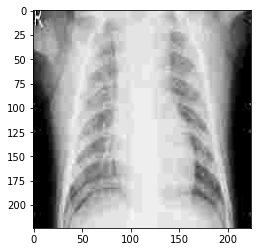

/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/test/NORMAL/NORMAL2-IM-0256-0001.jpeg


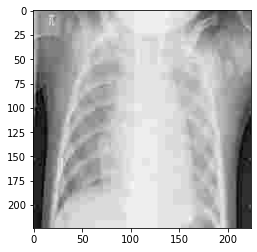

In [58]:
# Display some sample augmented images
databaseGen.reset()
counter = 1
for _ in range(2):
    filename = databaseGen.filenames[counter-1]
    augmented_img = databaseGen.next()
    print(filename)
    plt.imshow(custom_augmentation(augmented_img[0].astype('uint8')))
    plt.show()

/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/test/NORMAL/NORMAL2-IM-0256-0001.jpeg


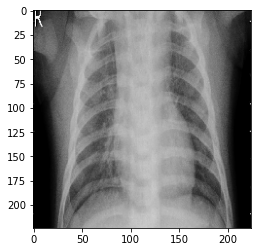

/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/test/PNEUMONIA/person150_bacteria_715.jpeg


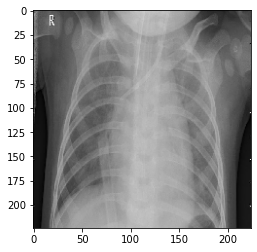

In [59]:
## display some sample images from the generator
databaseGen.reset()
counter = 1
for _ in range(2):
    filename = databaseGen.filenames[counter-1]
    augmented_img = databaseGen.next()
    print(filename)
    plt.imshow(augmented_img[0].astype('uint8'))
    plt.show()
    counter += 1
    

### Methodology: Perceptual Hashing
source: https://medium.com/analytics-vidhya/image-search-engine-using-image-hashing-technique-in-python-e6749dacc8f7


In [60]:
## Function to calculate perceptual hash given a single image, returns hash value in hex for storage efficiency
def calculate_hash(img):
    # resize image and convert to gray scale
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img, dtype = np.float32)
    # calculate dct of image 
    dct = cv2.dct(img)
    # to reduce hash length take only top-left block 
    # as this block has more information than the rest
    dct_block = dct[: 16, : 16]
    # caclulate mean of dct block excluding first term i.e, dct(0, 0)
    dct_average = (dct_block.mean() * dct_block.size - dct_block[0, 0]) / (dct_block.size - 1)
    # convert dct block to binary values based on dct_average
    dct_block[dct_block < dct_average] = 0.0
    dct_block[dct_block != 0] = 1.0
    # store hash value
    img_hash = hash_array_to_hash_hex(dct_block.flatten())
    return img_hash

In [61]:
%%time

## Populate the image hash/embedding database with the training set
databaseGen.reset()
counter = 1
for _ in tqdm(range(databaseGen.samples)):
    filename = databaseGen.filenames[counter-1]
    augmented_img = databaseGen.next()
    save_hash(filename, augmented_img[0].astype('uint8'))
    counter += 1
    

100%|██████████| 5270/5270 [04:03<00:00, 21.65it/s]

CPU times: user 1min 10s, sys: 1.75 s, total: 1min 12s
Wall time: 4min 3s


### Testing Framework
The framework performs a query tests on images from the testing set to see if it can be detected as a duplicate.

In [62]:

## test generator. This will be used to generate augmented images to our check_duplicate function
test_df['duplicate_label'] = test_df['duplicate_label'].astype(str)
testGen = imgAug.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='filename',
    y_col='duplicate_label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1,
    shuffle=False,
    validate_filenames=False
)
  

Found 556 non-validated image filenames belonging to 2 classes.


/tmp/ipykernel_14173/3887981349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['duplicate_label'] = test_df['duplicate_label'].astype(str)


In [63]:
%%time

## Make predictions on each duplicate to see how many we can catch
testGen.reset()
query_filenames = []
closest_filenames = []
closest_distances = []
counter = 1
for _ in tqdm(range(testGen.samples)):
    filename = testGen.filenames[counter-1]
    augmented_img, label = testGen.next()
    
    # Augment Here
    augmented_img = custom_augmentation(augmented_img[0].astype('uint8'))
    
    closest_image, closest_distance = check_duplicate(augmented_img)
    query_filenames.append(filename)
    closest_filenames.append(closest_image)
    closest_distances.append(closest_distance)
    counter += 1


100%|██████████| 556/556 [03:41<00:00,  2.51it/s]

CPU times: user 2min 35s, sys: 793 ms, total: 2min 36s
Wall time: 3min 41s


In [79]:
results_df = pd.DataFrame(
    {'query_filename': query_filenames,
     'closest_filename': closest_filenames,
     'closest_distance': closest_distances
    })

## Duplicate in this case will be defined by some threshold on similarity measurement between the hashes
predictions = []
for val in results_df['closest_distance']:
    if val < .15:
        predictions.append(1)
    else:
        predictions.append(0)
results_df["prediction"] = predictions
results_df["actual"] = testGen.classes
results_df

,query_filename,closest_filename,closest_distance,prediction,actual
0,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person1284_virus_2207.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/test/PNEUMONIA/person42_virus_89.jpeg,0.222656,0,0
1,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person58_bacteria_272.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person870_bacteria_2792.jpeg,0.246094,0,0
2,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person71_bacteria_348.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person1630_bacteria_4303.jpeg,0.296875,0,0
3,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person1133_virus_1865.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person1500_bacteria_3916.jpeg,0.320312,0,0
4,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person383_bacteria_1750.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person478_bacteria_2032.jpeg,0.250000,0,0
...,...,...,...,...,...
551,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person1496_bacteria_3907.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person1496_bacteria_3907.jpeg,0.066406,1,1
552,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/NORMAL/IM-0577-0001.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/NORMAL/IM-0577-0001.jpeg,0.078125,1,1
553,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person292_bacteria_1378.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person292_bacteria_1378.jpeg,0.070312,1,1
554,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person544_virus_1075.jpeg,/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person544_virus_1075.jpeg,0.082031,1,1


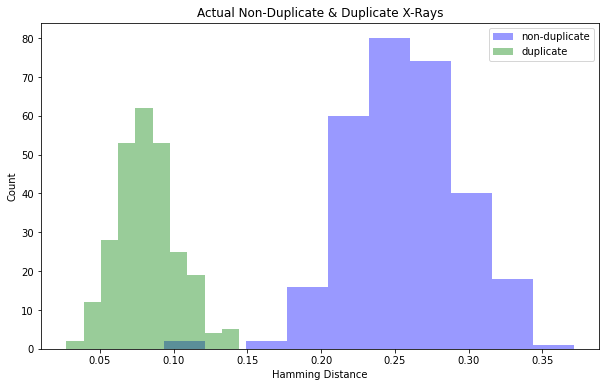

In [80]:
# Seperating the Actual test Results
non_duplicate_actual_results = results_df.loc[(results_df.actual == 0)]
duplicate_actual_results = results_df.loc[(results_df.actual == 1)]

x = non_duplicate_actual_results.closest_distance
y = duplicate_actual_results.closest_distance

# Histogram representing Actual Non-Duplicate and Duplicate X-Rays
plt.figure(figsize=(10, 6))
plt.hist(x, alpha=0.4,color='b', label='non-duplicate')
plt.hist(y,  alpha=0.4, color='g', label='duplicate')
plt.legend(loc='upper right')
plt.title('Actual Non-Duplicate & Duplicate X-Rays')
plt.xlabel('Hamming Distance')
plt.ylabel('Count')
plt.show()

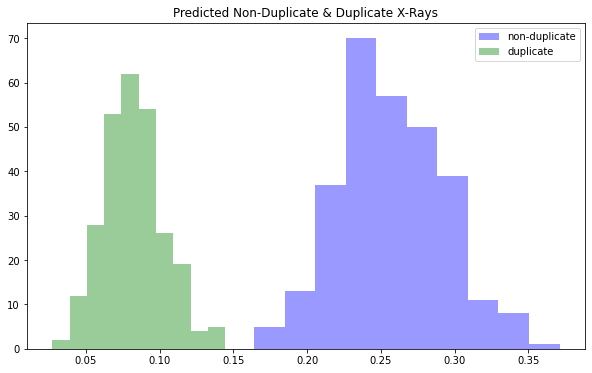

In [81]:
# Seperating the Predicited test Results

non_duplicate_predictions_results = results_df.loc[(results_df.prediction == 0) ]
duplicate_predictions_results = results_df.loc[(results_df.prediction == 1)]

x = non_duplicate_predictions_results.closest_distance
y = duplicate_predictions_results.closest_distance

# Histogram representing Predicted Non-Duplicate and Duplicate X-Rays
plt.figure(figsize=(10, 6))
plt.hist(x, alpha=0.4,color='b', label='non-duplicate')
plt.hist(y,  alpha=0.4, color='g', label='duplicate')
plt.legend(loc='upper right')
plt.title('Predicted Non-Duplicate & Duplicate X-Rays')
plt.show()

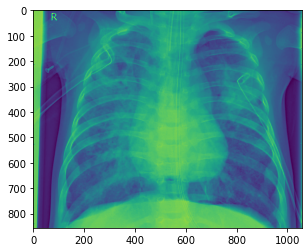

/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person258_bacteria_1208.jpeg


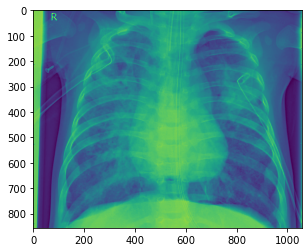

/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person258_bacteria_1209.jpeg


In [83]:
# Duplicate Images found in Dataset that are considered non-duplicate

display_image("/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person258_bacteria_1208.jpeg")
print("/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person258_bacteria_1208.jpeg")
display_image("/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person258_bacteria_1209.jpeg")
print("/mnt/azureblobshare/data/interim/mendeley-chestxray-2017/train/PNEUMONIA/person258_bacteria_1209.jpeg")

In [78]:
## calculate metrics
metrics = classification_report(testGen.classes, predictions, target_names=testGen.class_indices.keys(), output_dict=True)
metrics_df = pd.DataFrame(metrics).transpose()
metrics_df

,precision,recall,f1-score,support
0,0.993174,0.993174,0.993174,293.000000
1,0.992395,0.992395,0.992395,263.000000
accuracy,0.992806,0.992806,0.992806,0.992806
macro avg,0.992785,0.992785,0.992785,556.000000
weighted avg,0.992806,0.992806,0.992806,556.000000
